In [1]:
import torch
import h5py
import pandas as pd

In [2]:
class DNARNABindingDataset(torch.utils.data.Dataset):
    def __init__(self, h5_path="/Users/riyapatel/Documents/embeddings_filtered.h5", label_path="/Users/riyapatel/Documents/full_per_residue_labels.tsv"):
        self.h5_path = h5_path
        self.h5_file = h5py.File(self.h5_path, "r") 
        self.labels_df = pd.read_csv(label_path, sep="\t")

        # Mapping UniProt ID → binding labels
        self.label_map = {}
        for idx, row in self.labels_df.iterrows():
            uniprot_id = row['uniprot_id']
            sequence = row['sequence']
            binding_labels = row['binding_labels']
            self.label_map[uniprot_id] = (sequence, binding_labels)

        # Preprocess: Available embeddings
        self.available_keys = list(self.h5_file.keys())

        # Build matching protein list
        self.valid_keys = []
        for key in self.available_keys:
            # Remove "-F1" if exists
            stripped_key = key.split("-")[0]

            if stripped_key in self.label_map:
                self.valid_keys.append(key)

        print(f"Found {len(self.valid_keys)} proteins with both embeddings and labels.")

    def __len__(self):
        return len(self.valid_keys)

    def __getitem__(self, idx):
        key = self.valid_keys[idx]
        stripped_key = key.split("-")[0]
    
        # Load embedding
        embedding = torch.tensor(self.h5_file[key][:]).float()
    
        # Squeeze extra batch dimension if it exists
        if embedding.dim() == 3:
            embedding = embedding.squeeze(0)
    
        # Load labels
        sequence, binding_labels = self.label_map[stripped_key]
        labels = torch.tensor([int(c) for c in binding_labels], dtype=torch.float32)
    
        # Check that lengths match
        if embedding.shape[0] != len(labels):
            min_len = min(embedding.shape[0], len(labels))
            embedding = embedding[:min_len]
            labels = labels[:min_len]
    
        return embedding, labels



In [3]:
# Instantiate the dataset
dataset = DNARNABindingDataset(
    h5_path="/Users/riyapatel/Documents/embeddings_filtered.h5",
    label_path="/Users/riyapatel/Documents/full_per_residue_labels.tsv"
)

#Check one sample
print(len(dataset))  
embedding, labels = dataset[0]
print(embedding.shape)  
print(labels.shape)     


Found 570 proteins with both embeddings and labels.
570
torch.Size([867, 960])
torch.Size([867])


In [ ]:
import torch
import torch.nn as nn

class DNARNABindingCNN_Transformer(nn.Module):
    def __init__(self, embedding_dim=960, cnn_dim=256, n_heads=4, ff_dim=512, n_layers=1):
        super(DNARNABindingCNN_Transformer, self).__init__()

        # CNN Part
        self.conv1 = nn.Conv1d(embedding_dim, 512, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(512, cnn_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(cnn_dim)
        self.relu2 = nn.ReLU()

        self.dropout = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.2)

        # Transformer Encoder Part
        encoder_layer = nn.TransformerEncoderLayer(d_model=cnn_dim, nhead=n_heads, dim_feedforward=ff_dim, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Output
        self.fc = nn.Linear(cnn_dim, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, embedding_dim, n_residues)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.dropout(x)
        x = self.dropout2(x)

        x = x.permute(0, 2, 1)  

        # Transformer Encoder
        x = self.transformer_encoder(x)

        # Output Layer
        x = self.fc(x)
        x = x.squeeze(-1)

        return x


In [5]:
model = DNARNABindingCNN_Transformer(embedding_dim=960)
print(model)

DNARNABindingCNN_Transformer(
  (conv1): Conv1d(960, 512, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv1d(512, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)

Initiating Training Model

In [6]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import numpy as np

In [8]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probs = torch.sigmoid(inputs)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_term = (1 - pt) ** self.gamma
        loss = self.alpha * focal_term * bce_loss
        return loss.mean()

In [9]:
# Instantiate dataset
dataset = DNARNABindingDataset(
    h5_path="/Users/riyapatel/Documents/embeddings_filtered.h5",
    label_path="/Users/riyapatel/Documents/full_per_residue_labels.tsv"
)

Found 570 proteins with both embeddings and labels.


In [10]:
# Split dataset (simple random split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [11]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: x)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: x)

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DNARNABindingCNN_Transformer(embedding_dim=960, n_layers=2).to(device)

# Loss and optimizer
pos_weight = torch.tensor([2.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Early Stopping Setup
best_f1 = 0
patience = 15
counter = 0

# Training loop
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    train_losses = []

    for batch in train_loader:
        embeddings, labels = zip(*batch)  # list of tensors

        # Pad to max length in batch
        max_len = max(e.shape[0] for e in embeddings)

        embeddings_padded = []
        labels_padded = []

        for e, l in zip(embeddings, labels):
            pad_len = max_len - e.shape[0]
            e_padded = torch.nn.functional.pad(e, (0, 0, 0, pad_len))
            l_padded = torch.nn.functional.pad(l, (0, pad_len))
            embeddings_padded.append(e_padded)
            labels_padded.append(l_padded)

        embeddings_batch = torch.stack(embeddings_padded).to(device)
        if model.training:
            noise = torch.randn_like(embeddings_batch) * 0.01
            embeddings_batch = embeddings_batch + noise

        labels_batch = torch.stack(labels_padded).to(device)

        optimizer.zero_grad()
        outputs = model(embeddings_batch)

        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(train_losses):.4f}")

    # Validation
    model.eval()
    val_losses = []
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in val_loader:
            embeddings, labels = zip(*batch)

            max_len = max(e.shape[0] for e in embeddings)

            embeddings_padded = []
            labels_padded = []

            for e, l in zip(embeddings, labels):
                pad_len = max_len - e.shape[0]
                e_padded = torch.nn.functional.pad(e, (0, 0, 0, pad_len))
                l_padded = torch.nn.functional.pad(l, (0, pad_len))
                embeddings_padded.append(e_padded)
                labels_padded.append(l_padded)

            embeddings_batch = torch.stack(embeddings_padded).to(device)
            labels_batch = torch.stack(labels_padded).to(device)

            outputs = model(embeddings_batch)

            loss = criterion(outputs, labels_batch)
            val_losses.append(loss.item())

            preds = torch.sigmoid(outputs).detach().cpu().numpy().flatten()
            labels_flat = labels_batch.detach().cpu().numpy().flatten()

            y_true.extend(labels_flat)
            y_pred.extend(preds)

    # Compute metrics
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    val_loss = np.mean(val_losses)
    auc = roc_auc_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)
    preds_binary = (y_pred >= 0.20).astype(int)
    f1 = f1_score(y_true, preds_binary)

    print(f"Validation Loss: {val_loss:.4f} | AUC: {auc:.4f} | AP: {ap:.4f} | F1: {f1:.4f}")

    # --- Early stopping check here! ---
    if f1 > best_f1:
        best_f1 = f1
        counter = 0  # reset patience counter
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


Epoch 1/30 - Train Loss: 0.2104
Validation Loss: 0.1701 | AUC: 0.8381 | AP: 0.1272 | F1: 0.1626
Epoch 2/30 - Train Loss: 0.1690
Validation Loss: 0.1650 | AUC: 0.8668 | AP: 0.1500 | F1: 0.2136
Epoch 3/30 - Train Loss: 0.1560
Validation Loss: 0.1771 | AUC: 0.8436 | AP: 0.1402 | F1: 0.1604
Epoch 4/30 - Train Loss: 0.1484
Validation Loss: 0.1692 | AUC: 0.8704 | AP: 0.1362 | F1: 0.2084
Epoch 5/30 - Train Loss: 0.1406
Validation Loss: 0.1741 | AUC: 0.8640 | AP: 0.1414 | F1: 0.1905
Epoch 6/30 - Train Loss: 0.1339
Validation Loss: 0.1742 | AUC: 0.8776 | AP: 0.1487 | F1: 0.2107
Epoch 7/30 - Train Loss: 0.1264
Validation Loss: 0.1837 | AUC: 0.8750 | AP: 0.1534 | F1: 0.1966
Epoch 8/30 - Train Loss: 0.1210
Validation Loss: 0.1758 | AUC: 0.8755 | AP: 0.1484 | F1: 0.2118
Epoch 9/30 - Train Loss: 0.1160
Validation Loss: 0.1866 | AUC: 0.8663 | AP: 0.1403 | F1: 0.1933
Epoch 10/30 - Train Loss: 0.1119
Validation Loss: 0.2083 | AUC: 0.8678 | AP: 0.1364 | F1: 0.1864
Epoch 11/30 - Train Loss: 0.1050
Valida

In [24]:
torch.save(model.state_dict(), "dna_rna_binding_model_cnn1.pth")

In [25]:
model = DNARNABindingCNN_Transformer(embedding_dim=960)
model.load_state_dict(torch.load("dna_rna_binding_model_cnn1.pth"))
model.eval()

DNARNABindingCNN_Transformer(
  (conv1): Conv1d(960, 512, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv1d(512, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)

Determining Best Threshold

In [12]:
import numpy as np
from sklearn.metrics import f1_score

def find_best_threshold(y_true, y_pred_probs):
    best_thresh = 0.5
    best_f1 = 0.0

    thresholds = np.arange(0.05, 0.95, 0.05)

    for thresh in thresholds:
        preds = (y_pred_probs > thresh).astype(int)
        f1 = f1_score(y_true, preds)

        print(f"Threshold {thresh:.2f}: F1 = {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    print(f"Best threshold: {best_thresh:.2f} with F1: {best_f1:.4f}")
    return best_thresh


In [13]:
best_threshold = find_best_threshold(y_true, y_pred)

Threshold 0.05: F1 = 0.1923
Threshold 0.10: F1 = 0.2018
Threshold 0.15: F1 = 0.2063
Threshold 0.20: F1 = 0.2080
Threshold 0.25: F1 = 0.2043
Threshold 0.30: F1 = 0.2004
Threshold 0.35: F1 = 0.1963
Threshold 0.40: F1 = 0.1842
Threshold 0.45: F1 = 0.1771
Threshold 0.50: F1 = 0.1657
Threshold 0.55: F1 = 0.1586
Threshold 0.60: F1 = 0.1411
Threshold 0.65: F1 = 0.1299
Threshold 0.70: F1 = 0.1150
Threshold 0.75: F1 = 0.0996
Threshold 0.80: F1 = 0.0815
Threshold 0.85: F1 = 0.0646
Threshold 0.90: F1 = 0.0405
Best threshold: 0.20 with F1: 0.2080


Plotting ROC & PR

In [16]:
 pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def plot_roc_pr(y_true, y_pred):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # PR Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(14, 6))

    # ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # PR
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AP = {pr_auc:.3f}')
    plt.title('Precision-Recall (PR) Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    plt.show()


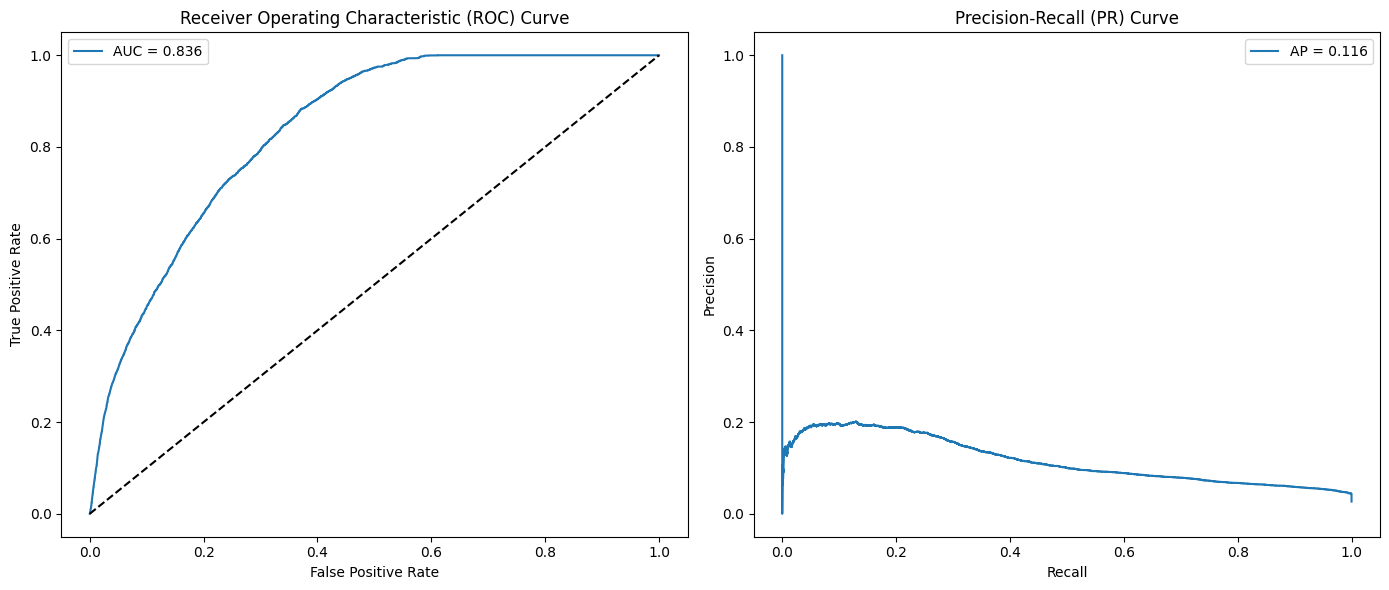

In [18]:
plot_roc_pr(y_true, y_pred)


Plotting Training and Validation Loss Curves

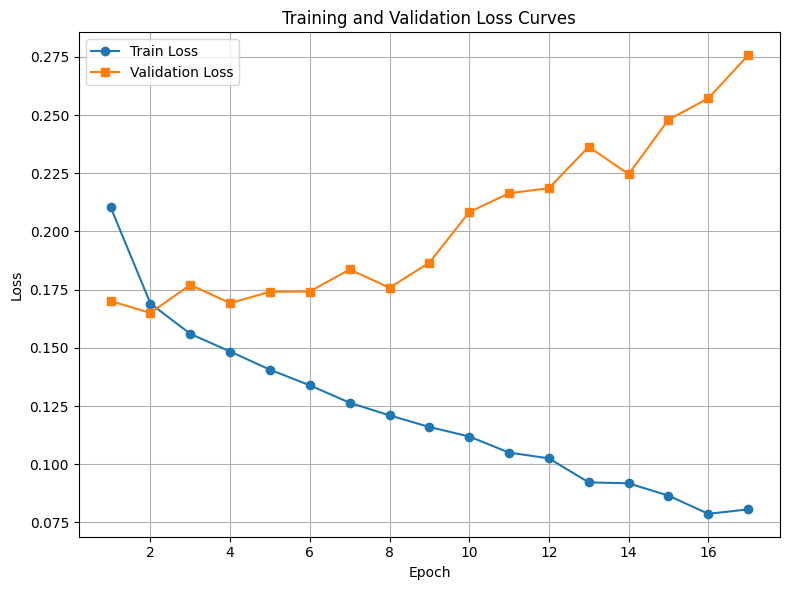

In [ ]:
import matplotlib.pyplot as plt

train_losses_per_epoch = [
    0.2104, 0.1690, 0.1560, 0.1484, 0.1406, 0.1339, 0.1264, 0.1210, 0.1160,
    0.1119, 0.1050, 0.1025, 0.0922, 0.0918, 0.0865, 0.0787, 0.0806
]

val_losses_per_epoch = [
    0.1701, 0.1650, 0.1771, 0.1692, 0.1741, 0.1742, 0.1837, 0.1758, 0.1866,
    0.2083, 0.2164, 0.2186, 0.2364, 0.2246, 0.2480, 0.2572, 0.2757
]

# 📈 Now plot it
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses_per_epoch)+1), train_losses_per_epoch, marker='o', label='Train Loss')
plt.plot(range(1, len(val_losses_per_epoch)+1), val_losses_per_epoch, marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


F1 Score vs Threshold

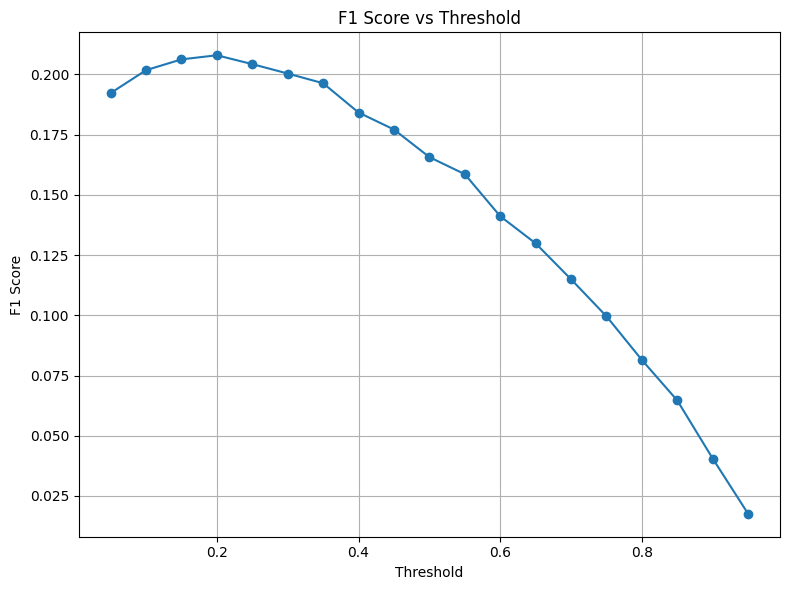

In [22]:
from sklearn.metrics import f1_score
import numpy as np

thresholds = np.linspace(0.05, 0.95, 19)
f1_scores = []

for thresh in thresholds:
    preds_bin = (y_pred >= thresh).astype(int)
    f1 = f1_score(y_true, preds_bin)
    f1_scores.append(f1)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.tight_layout()
plt.show()


Class Balance in Dataset

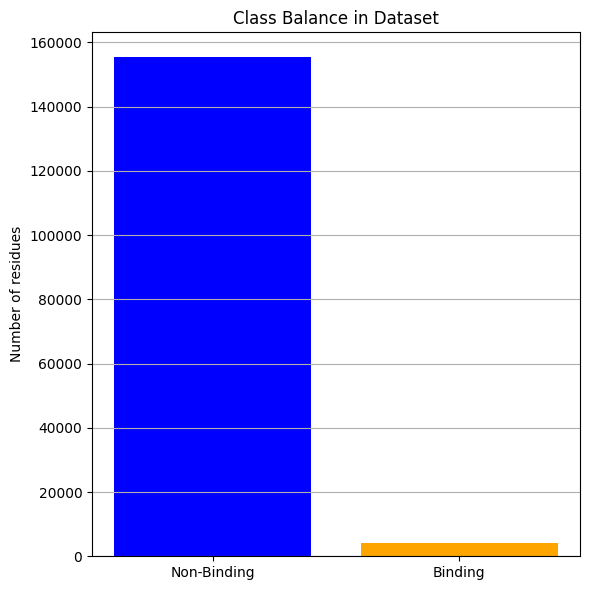

In [23]:
import numpy as np

y_true_np = np.array(y_true)
binding = np.sum(y_true_np == 1)
non_binding = np.sum(y_true_np == 0)

plt.figure(figsize=(6, 6))
plt.bar(['Non-Binding', 'Binding'], [non_binding, binding], color=['blue', 'orange'])
plt.ylabel('Number of residues')
plt.title('Class Balance in Dataset')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
